In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("train/train_metadata.csv")
train_data_additional = pd.read_csv("train/Features/additional_features.csv")
train_data_color_histogram = pd.read_csv("train/Features/color_histogram.csv")
train_data_hog_pca = pd.read_csv("train/Features/hog_pca.csv")

train_features = pd.merge(train_data_color_histogram, train_data_hog_pca, on='image_path')
train_features = pd.merge(train_features, train_data_additional, on='image_path')
train_features = pd.merge(train_features, train_data[['image_path', 'ClassId']], on='image_path')

print(train_features.head())

       image_path      ch_0      ch_1      ch_2      ch_3      ch_4      ch_5  \
0  img_000001.jpg  0.000000  0.000000  0.268901  0.355617  0.511548  0.264923   
1  img_000002.jpg  0.000000  0.002267  0.657901  0.641467  0.222700  0.243100   
2  img_000003.jpg  0.002243  0.143541  0.385766  0.091956  0.066163  0.204097   
3  img_000004.jpg  0.000000  0.096069  0.947646  0.217350  0.160404  0.083028   
4  img_000005.jpg  0.000000  0.000000  0.000000  0.000000  0.000000  0.015324   

       ch_6      ch_7      ch_8  ...  hog_pca_15  hog_pca_16  hog_pca_17  \
0  0.526664  0.321408  0.097059  ...    0.450825   -0.213796   -0.882416   
1  0.108233  0.036833  0.021533  ...   -0.335682   -0.886182    0.507969   
2  0.353245  0.218676  0.222040  ...    0.501386   -0.421448    0.081289   
3  0.042601  0.045209  0.040427  ...    0.285638   -0.481589   -0.101580   
4  0.029918  0.024810  0.097779  ...   -0.520063    0.062209    0.248771   

   hog_pca_18  hog_pca_19  edge_density      mean_b     

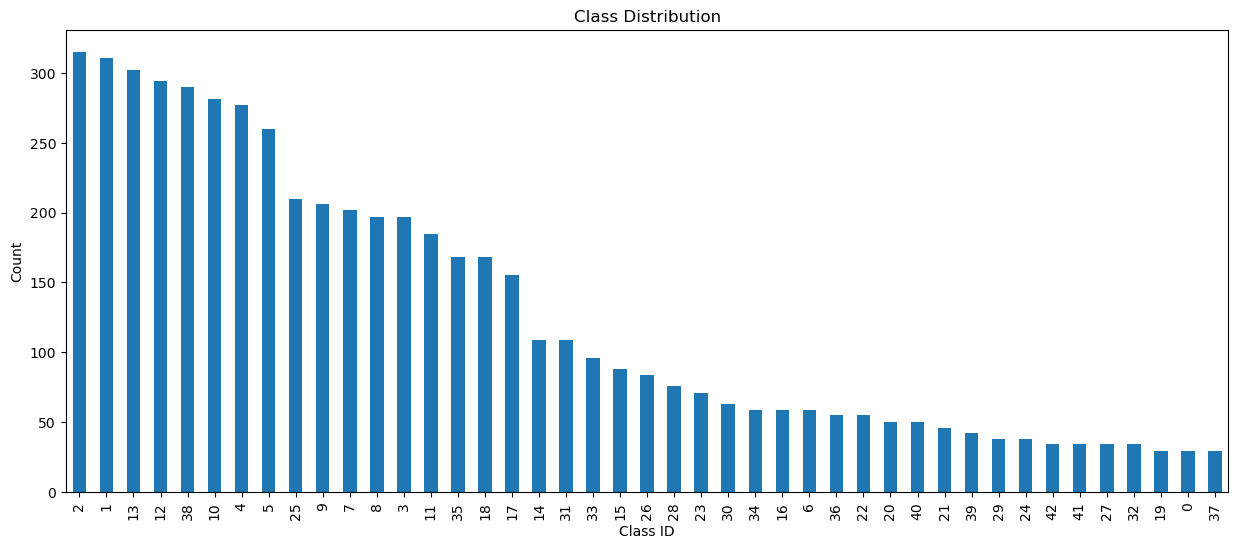

In [4]:
# checking for class imbalance
class_counts = train_features['ClassId'].value_counts()
# print(class_counts)

plt.figure(figsize=(15, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.show()

from sklearn.preprocessing import StandardScaler

feature_columns = [col for col in train_features.columns if col not in ['image_path', 'ClassId']]
train_features[feature_columns] = StandardScaler().fit_transform(train_features[feature_columns])

In [5]:
# getting the top 20 features most correlated with class
correlations = []
for col in train_features.columns:
    if col not in ['image_path', 'ClassId']:
        corr = train_features[col].corr(train_features['ClassId'])
        correlations.append((col, corr))

top_correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)[:20]
for feature, corr in top_correlations:
    print(f"{feature}: {corr:.4f}")

hog_pca_0: 0.3682
hog_pca_7: 0.3309
hog_pca_3: -0.3275
hog_pca_8: 0.3137
hog_pca_2: -0.2958
hog_pca_12: -0.1667
mean_b: 0.1468
ch_3: -0.1236
hog_pca_6: 0.1207
ch_2: -0.1175
hog_pca_1: -0.1153
hog_pca_9: -0.1146
hog_pca_4: 0.1098
ch_30: 0.1041
ch_4: -0.0920
ch_34: -0.0857
ch_13: 0.0807
ch_12: 0.0779
ch_61: 0.0753
ch_29: 0.0744


# Image Processsing

0
0
0
1
0


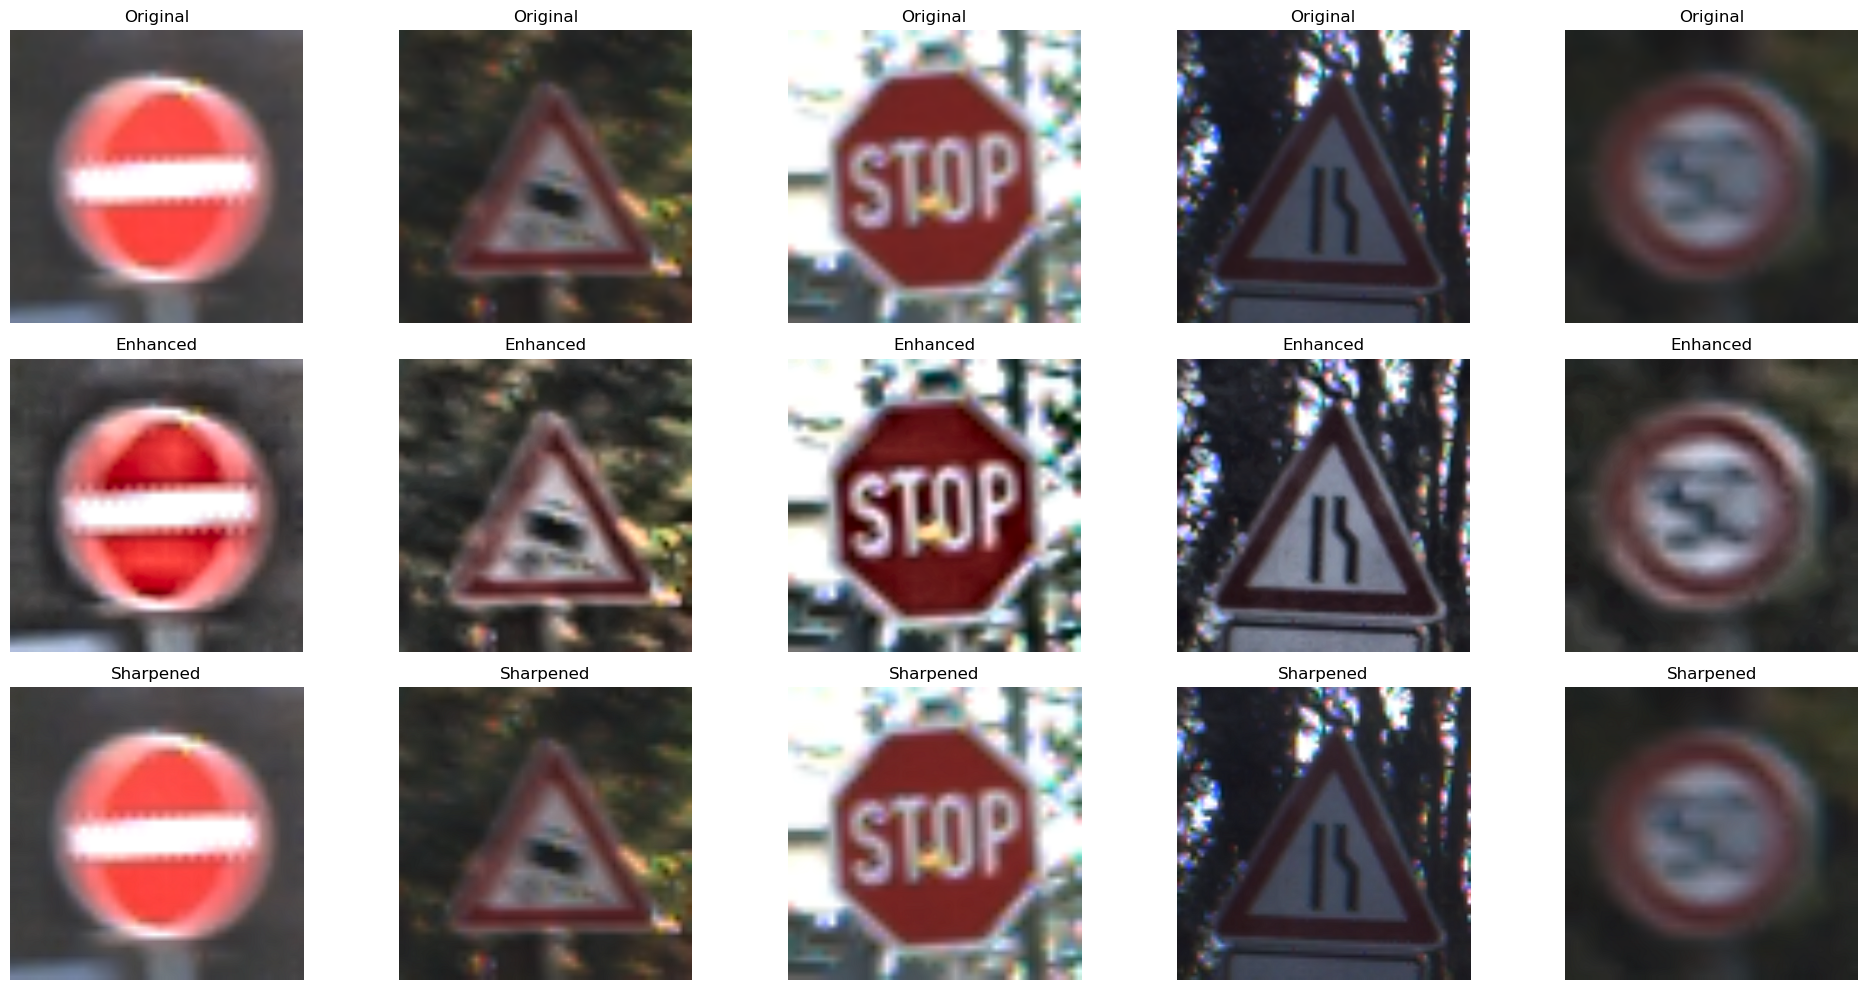

In [44]:
# image enhancement and normalization
import cv2
import os
from tqdm import tqdm

# loads and resizes image to 1000 x 1000 pixels
def load_image(path):
    path = os.path.join('train', path)  
    img = cv2.imread(path)
    img = cv2.resize(img, (1000, 1000))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# gotten from https://www.youtube.com/watch?v=kSqxn6zGE0c
def sharpen_img(img):
    kernel_sharpening = np.array([[-1, -1, -1,],
                                  [-1, 9, -1,],
                                  [-1, -1, -1]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpening)

    return sharpened

def enhance_image(img):
    # converting to LAB color space so we can up teh brightness without affecting colors
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # applying CLAHE to only the brightness channel 
    # clipLimit controls the contrast and tileGridSize divides the image into regions for local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    
    # converting back to RGB then normalising
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    enhanced = enhanced / 255.0
    
    return enhanced      

# def detect_circle(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Blur using 3 * 3 kernel.
#     gray_blurred = cv2.blur(gray, (3, 3))

#     # Apply Hough transform on the blurred image.
#     detected_circles = cv2.HoughCircles(gray_blurred, 
#                     cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
#                 param2 = 30, minRadius = 1, maxRadius = 40)

#     # Draw circles that are detected.
#     if detected_circles is not None:

#         # Convert the circle parameters a, b and r to integers.
#         detected_circles = np.uint16(np.around(detected_circles))

#         for pt in detected_circles[0, :]:
#             a, b, r = pt[0], pt[1], pt[2]

#             # Draw the circumference of the circle.
#             cv2.circle(img, (a, b), r, (0, 255, 0), 2)

#             # Draw a small circle (of radius 1) to show the center.
#             cv2.circle(img, (a, b), 1, (0, 0, 255), 3)
#             cv2.imshow("Detected Circle", img)
#             cv2.waitKey(0)

# modified circle detection function from 
# https://www.geeksforgeeks.org/circle-detection-using-opencv-python/
def detect_circle(img):
    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur using 3 * 3 kernel.
    gray_blurred = cv2.blur(gray, (3, 3))

    # Apply Hough transform on the blurred image
    detected_circles = cv2.HoughCircles(gray_blurred, 
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
               param2 = 30, minRadius = 1, maxRadius = 40)

    return 1 if detected_circles is not None else 0

# Demonstrate enhancement on a few images
# written by claude
sample_images = train_features['image_path'].values[5:10]
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(sample_images):
    img = load_image(img_path)
    if img is not None:
        sharpened = sharpen_img(img)
        enhanced = enhance_image(img)
        circle = detect_circle(sharpened)
        print(circle)
        
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(3, 5, i+6)
        plt.imshow(enhanced)
        plt.title('Enhanced')
        plt.axis('off')

        plt.subplot(3, 5, i+11)
        plt.imshow(sharpened)
        plt.title('Sharpened')
        plt.axis('off')

plt.tight_layout()
# plt.show()



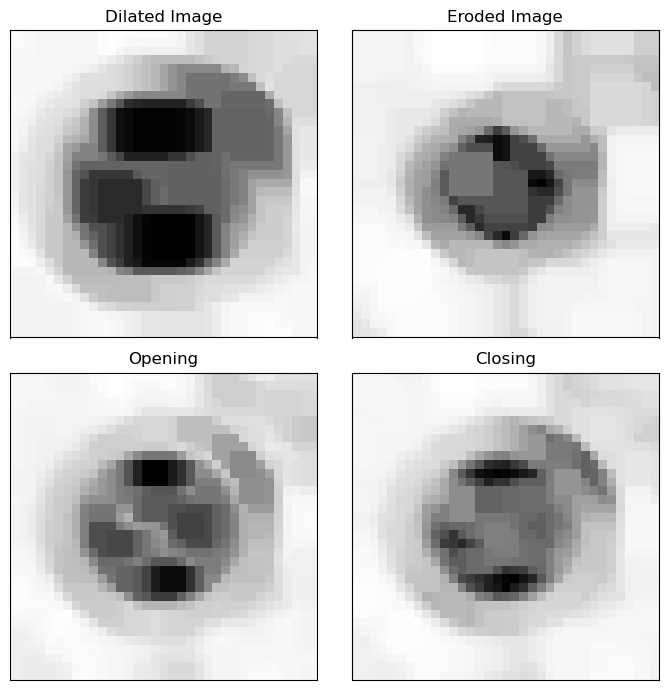

In [15]:
image = cv2.imread('train/img_000010.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.ones((3, 3), np.uint8)

dilated = cv2.dilate(image_gray, kernel, iterations=2)
eroded = cv2.erode(image_gray, kernel, iterations=2)
opening = cv2.morphologyEx(image_gray, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(image_gray, cv2.MORPH_CLOSE, kernel)

fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs[0, 0].imshow(dilated, cmap='Greys'), axs[0, 0].set_title('Dilated Image')
axs[0, 1].imshow(eroded, cmap='Greys'), axs[0, 1].set_title('Eroded Image')
axs[1, 0].imshow(opening, cmap='Greys'), axs[1, 0].set_title('Opening')
axs[1, 1].imshow(closing, cmap='Greys'), axs[1, 1].set_title('Closing')

for ax in axs.flatten():
    ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

In [158]:
from sklearn.model_selection import train_test_split

# CHECK WORKSHOP 5 FOR TEST TRAIN EVALUATION CRAP
X = train_features.drop(['image_path', 'ClassId'], axis=1)
y = train_features['ClassId']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.33, random_state=30027, stratify=y)

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

# Define the parameter grid to search over
# param_grid = {'max_iter': [100, 500, 1000, 5000, 10000]}
# param_grid = {'max_iter': [5000, 7500, 10000]}
# param_grid = {'max_iter': [5000, 6250, 7500]}
# param_grid = {'max_iter': [6000, 6250, 6500]}
param_grid = {'max_iter': [6200, 6250, 6300]}

# Create a logistic regression classifier
lgr = LogisticRegression()

print("This will take a while. Be Patient!")

# Use GridSearchCV to find the best max_iter value
grid_search = GridSearchCV(lgr, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Print the best parameters and accuracy score
print("Best max_iter value:", grid_search.best_params_['max_iter'])
print("Accuracy:", grid_search.score(X_eval, y_eval))

This will take a while. Be Patient!
Best max_iter value: 6250
Accuracy: 0.7935982339955849


In [91]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#print(cross_val_score(zero_r, X, y, cv=10))

#try to change C to 1000 or 0.001
C = 1.0  # SVM regularization parameter

models = [GaussianNB(),
        #   MultinomialNB(),
          # DecisionTreeClassifier(max_depth=1), #Cross Validation Acc 0.11024124818847805
          KNeighborsClassifier(n_neighbors=1),
          KNeighborsClassifier(n_neighbors=5),
          DecisionTreeClassifier(max_depth=None),
          svm.LinearSVC(C=C),
          # svm.SVC(kernel='rbf', gamma=0.7, C=C), #Cross Validation Acc 0.15761105128102856
          # svm.SVC(kernel='poly', degree=3, C=C), #Cross Validation Acc 0.13228730405647962
          LogisticRegression(max_iter=6250),
          RandomForestClassifier(n_estimators=100, random_state=30027)          ]

titles = ['Naives Bayes',
        #   'Multinomial Naives Bayes',
          # '1-R',
          '1-Nearest Neighbour',
          '5-Nearest Neighbour',
          'Decision Tree',
          'LinearSVC',
          # 'SVM with a cubic kernel',
          # 'SVM with an RBF kernel',
          'Logistic Regression',
          'Random Forest']

# title_training_acc = {}
# for title, model in zip(titles, models):
#     model.fit(X_train, y_train)
#     title_training_acc[title] = model.score(X_eval, y_eval)

title_crossvalidation_acc = {}
for title, model in zip(titles, models):
    title_crossvalidation_acc[title] = np.mean(cross_val_score(model, X, y, cv=10))

# for title in titles:
#     print(title, ': Training Acc', title_training_acc[title], '; Cross Validation Acc', title_crossvalidation_acc[title])

for title in titles:
    print(title, '; Cross Validation Acc', title_crossvalidation_acc[title])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/

Naives Bayes ; Cross Validation Acc 0.22303225506228977
1-Nearest Neighbour ; Cross Validation Acc 0.5076439578264396
5-Nearest Neighbour ; Cross Validation Acc 0.3647870049060668
Decision Tree ; Cross Validation Acc 0.5461097150758513
LinearSVC ; Cross Validation Acc 0.5426372435616184
Logistic Regression ; Cross Validation Acc 0.814319997872708
Random Forest ; Cross Validation Acc 0.8022984723385583


In [92]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

np.random.seed(30027)

class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X) #X_meta is the output (y_hat) of the base classifiers
        self.metaclassifier.fit(X_meta, y) #output of the base classifiers is the input for the meta classifier
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0] # check that the number of rows yhats matches the number of rows in the input data X
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)
    

# classifiers = [ KNeighborsClassifier(n_neighbors=1),
#                 DecisionTreeClassifier(max_depth=None),
#                 # svm.LinearSVC(C=C),
#                 LogisticRegression(max_iter=6250),
#                 RandomForestClassifier(n_estimators=100, random_state=30027)]
# titles = ['1-Nearest Neighbour',
#           'Decision Tree',
#         #   'LinearSVC',
#           'Logistic Regression',
#           'Random Forest']
    
classifiers = [ LogisticRegression(max_iter=6250),
                RandomForestClassifier(n_estimators=100, random_state=30027)]
titles = ['Logistic Regression',
          'Random Forest']

meta_classifier_lr = LogisticRegression()
stacker_lr = StackingClassifier(classifiers, meta_classifier_lr)

meta_classifier_dt = DecisionTreeClassifier()
stacker_dt = StackingClassifier(classifiers, meta_classifier_dt)

stacker_lr.fit(X_train, y_train)
print('\nStacker Accuracy (Logistic Regression):', stacker_lr.score(X_eval, y_eval))

stacker_dt.fit(X_train, y_train)
print('\nStacker Accuracy (Decision Tree):', stacker_dt.score(X_eval, y_eval))


Stacker Accuracy (Logistic Regression): 0.6721854304635762

Stacker Accuracy (Decision Tree): 0.41280353200883


In [100]:
from sklearn.ensemble import BaggingClassifier

logreg = LogisticRegression(max_iter=6250)
bagging = BaggingClassifier(estimator=LogisticRegression(max_iter=6250), n_estimators=50,\
                              max_samples=0.5, max_features=0.5)
logreg.fit(X_train,y_train)
bagging.fit(X_train,y_train)

print("Logreg:",logreg.score(X_eval,y_eval))
print("Logreg Bagging Accuracy:",bagging.score(X_eval,y_eval))

Logreg: 0.7935982339955849
Logreg Bagging Accuracy: 0.6964679911699779


In [125]:
test_data = pd.read_csv("test/test_metadata.csv")
test_data_additional = pd.read_csv("test/Features/additional_features.csv")
test_data_color_histogram = pd.read_csv("test/Features/color_histogram.csv")
test_data_hog_pca = pd.read_csv("test/Features/hog_pca.csv")

test_features = pd.merge(test_data_color_histogram, test_data_hog_pca, on='image_path')
test_features = pd.merge(test_features, test_data_additional, on='image_path')
test_features = pd.merge(test_features, test_data[['image_path', 'ClassId']], on='image_path')

test_feature_columns = [col for col in train_features.columns if col not in ['image_path', 'ClassId']]
test_features[test_feature_columns] = StandardScaler().fit_transform(test_features[test_feature_columns])

X_test = test_features.drop(['image_path', 'ClassId'], axis=1)

lg = LogisticRegression(max_iter=6250)
lg.fit(X, y)
y_predicted_lg = lg.predict(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=30027)
rf.fit(X, y)
y_predicted_rf = rf.predict(X_test)

# stacker_lr.fit(X, y)
# y_predicted_stacker_lr = stacker_lr.predict(X_test)


In [126]:
submission_lg = pd.DataFrame({
    'id': test_data['id'],
    'ClassId': y_predicted_lg
})
print(submission_lg.head())
submission_lg.to_csv('submission_lg_with_scaling.csv', index=False)

submission_rf = pd.DataFrame({
    'id': test_data['id'],
    'ClassId': y_predicted_rf
})
print(submission_rf.head())
submission_rf.to_csv('submission_rf_with_scaling.csv', index=False)

# submission_stacker_lr = pd.DataFrame({
#     'id': test_data['id'],
#     'ClassId': y_predicted_stacker_lr
# })
# print(submission_stacker_lr.head())
# submission_stacker_lr.to_csv('submission_stacker_1nn_dt_lr_rf.csv', index=False)

     id  ClassId
0   661       12
1  4477        2
2  1046       10
3   631        5
4  6533        1
     id  ClassId
0   661       12
1  4477        9
2  1046        2
3   631        4
4  6533        3


In [ ]:
# code structure gotten from https://scikit-learn.org/stable/user_guide.html and past workshops
from sklearn.metrics import accuracy_score

# 1. Naives Bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
y_pred = nb_model.fit(X_train, y_train).predict(X_eval)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_eval.shape[0], (y_eval != y_pred).sum()))
print("Naive Bayes Accuracy:", nb_model.score(X_eval, y_eval))
print("Naive Bayes Accuracy:", accuracy_score(y_pred, y_eval))
print()

# 2. Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_gini = DecisionTreeClassifier(max_depth=None)
dt_gini.fit(X_train, y_train)
dt_IG = DecisionTreeClassifier(max_depth=None, criterion="entropy")
dt_IG.fit(X_train, y_train)

dt_gini_acc = dt_gini.score(X_eval, y_eval)
dt_IG_acc = dt_IG.score(X_eval, y_eval)
print("Information Gain/entropy: DT Gini accuracy: {} DT IG accuracy: {}".format(dt_gini_acc, dt_IG_acc))

feature_names = train_features.columns.tolist()

importances = dt_gini.feature_importances_
max_index_dt_gini = np.argmax(importances)
best_feature_name_dt_gini = feature_names[max_index_dt_gini]
print("DT Gini most important attribute: ", best_feature_name_dt_gini)

importances = dt_IG.feature_importances_
max_index_dt_IG = np.argmax(importances)
best_feature_name_dt_IG = feature_names[max_index_dt_IG]
print("DT IG most important attribute: ", best_feature_name_dt_IG)
print()

# 3. 
